In [1]:
from floppity import Retrieval, helpers
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import torch
# from corner import corner
from tqdm import trange
from corner import corner
from floppity.simulators import read_ARCiS_input, ARCiS, mock_simulator

### Create simulator (function that takes parameters and returns spectra)

In [2]:
def gaussian(x, centers, sigmas, amplitudes):
    """Add multiple Gaussian features.

    Args:
        x (np.ndarray): Input x-axis (e.g., wavelengths).
        centers (list): List of Gaussian centers.
        sigmas (list): List of Gaussian standard deviations.
        amplitudes (list): List of Gaussian amplitudes.

    Returns:
        np.ndarray: Sum of all Gaussian features evaluated at x.
    """
    y = np.ones_like(x)
    for c, s, a in zip(centers, sigmas, amplitudes):
        y -= a * np.exp(-0.5 * ((x - c) / (s)) ** 2)
    return y

def simulator(obs, pars, thread=0):
    ndims=pars.shape[1]

    c=pars[:,0:ndims//3]
    s=pars[:,ndims//3:2*ndims//3]
    a=pars[:,2*ndims//3:3*ndims//3]
    
    x = {}
    for key in obs.keys():
        wvl = obs[key][:,0]
        x[key] = np.empty([len(c), len(wvl)])
        for i in trange(len(c)):
            x[key][i]=gaussian(wvl, c[i], s[i], a[i])
    return x

### Create synthetic observation to test

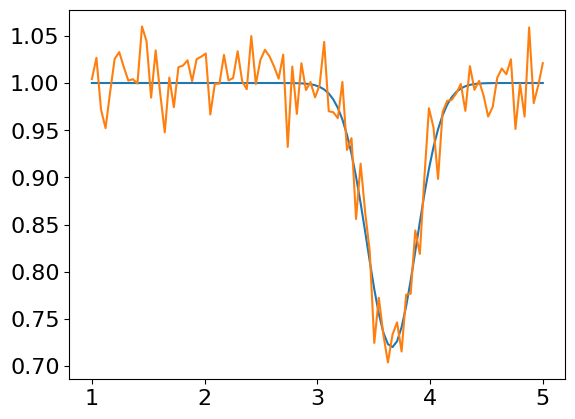

In [ ]:
wvl = np.linspace(1,5,100)
f = gaussian(wvl, [3.66], [0.22], [0.28])
noise=0.03*np.random.standard_normal(len(wvl))
plt.plot(wvl, f)
plt.plot(wvl, f+noise)

synthobs = helpers.create_obs_file(wvl, f+noise, 0.03*np.ones_like(f))

np.savetxt("../src/floppity/data/obs_3.66_0.22_0.28.txt", synthobs)

### Run nested sampling to have as baseline

In [8]:
import dynesty

synthobs = np.loadtxt('../src/floppity/data/obs_3.66_0.22_0.28.txt')

def log_likelihood(x):
    OBS = synthobs
    simulated = gaussian(OBS[:,0],[x[0]], [x[1]], [x[2]])
    residual = OBS[:,1] - simulated
    log_L = -0.5 * np.sum((residual**2 / OBS[:,2]**2) + np.log(2 * np.pi * OBS[:,2]**2))
    return log_L


def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior"""
    x=np.array(u)
    x[0]=1+4*u[0]
    x[1]=0.1+0.6*u[1]
    x[2]=u[2]

    return x

In [9]:
sampler = dynesty.NestedSampler(log_likelihood, ptform, 3, nlive=500)
sampler.run_nested(dlogz=0.1)

8838it [00:07, 1153.03it/s, +500 | bound: 25 | nc: 1 | ncall: 36675 | eff(%): 25.813 | loglstar:   -inf < 290.275 <    inf | logz: 274.956 +/-  0.168 | dlogz:  0.000 >  0.100]  


In [10]:
sresults = sampler.results

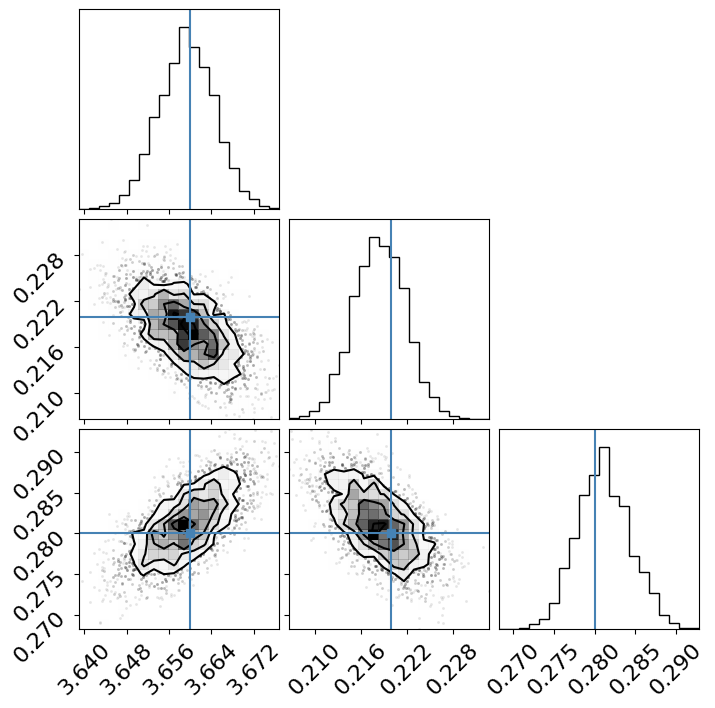

In [11]:
from corner import corner
fig=corner(sresults.samples_equal(),
truths=[3.66, 0.22, 0.28])

## Single retrieval

### Setup retrieval

In [55]:
R = Retrieval(mock_simulator)

### Get observation
R.get_obs(["../src/floppity/data/obs_3.66_0.22_0.28.txt"])

### Add parameters
R.add_parameter('center', 1, 5)
R.add_parameter('sigma', 0.1, 0.7)
R.add_parameter('amplitude', 0, 1)
# R.add_parameter('wvl_offset', -1,1, post_process=True)

In [56]:
training_kwargs= dict(
    stop_after_epochs = 20,
    num_atoms = 10,
    learning_rate=5e-4
)

flow_kwargs=dict(
    flow='nsf',
    bins=5,
    transforms=8,
    blocks=2,
    hidden=32,
    dropout=0.25,
    tail_bound=2
)

### Run retrieval

In [57]:
R.run(
    flow_kwargs=flow_kwargs, 
    resume=False, 
    n_threads=1,
    n_aug=1, 
    training_kwargs=training_kwargs, 
    n_rounds=3, 
    # n_samples_init=500,
    n_samples=1000
    )

Starting training...
Round 1
 Neural network successfully converged after 241 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 241
        Best validation performance: -7.2771
        -------------------------
        
Round 2


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 72
        Best validation performance: -9.7377
        -------------------------
        
Round 3


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 41
        Best validation performance: -11.9933
        -------------------------
        


### Save retrieval object

In [27]:
R.save('/Users/floppityflappity/Work/R_1405.pkl')

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/cloudpickle/cloudpickle.py:1303: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  return super().dump(obj)


### Load retrieval object

In [4]:
R=Retrieval.load('r.pkl')

### Resume training

In [16]:
R.run(flow_kwargs=flow_kwargs, resume=True, n_threads=1, training_kwargs=training_kwargs, n_rounds=5, n_samples=100)

Resuming training...
Round 1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.
        -------------------------
        ||||| ROUND 11 STATS |||||:
        -------------------------
        Epochs trained: 32
        Best validation performance: -7.4504
        -------------------------
        
Round 2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 13 epochs.
        -------------------------
        ||||| ROUND 12 STATS |||||:
        -------------------------
        Epochs trained: 13
        Best validation performance: -7.4196
        -------------------------
        
Round 3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 6 epochs.
        -------------------------
        ||||| ROUND 13 STATS |||||:
        -------------------------
        Epochs trained: 6
        Best validation performance: -7.0663
        -------------------------
        
Round 4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.
        -------------------------
        ||||| ROUND 14 STATS |||||:
        -------------------------
        Epochs trained: 26
        Best validation performance: -7.9274
        -------------------------
        
Round 5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.
        -------------------------
        ||||| ROUND 15 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -8.6456
        -------------------------
        


### Plot loss evolution

Text(0, 0.5, 'Loss')

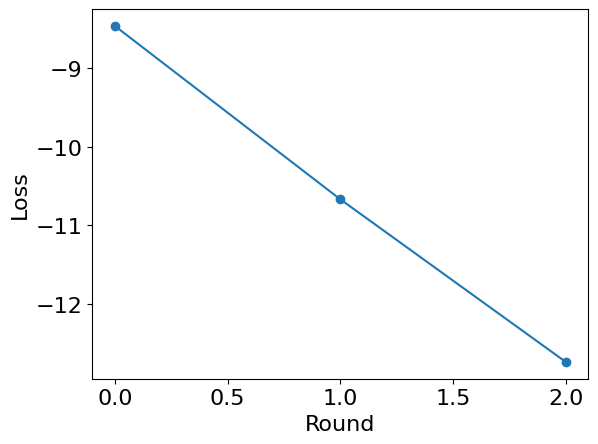

In [42]:
plt.plot(R.inference._summary['best_validation_loss'], marker='o', label=f'{len(R.proposals)}x{R.n_samples}')
plt.xlabel('Round')
plt.ylabel('Loss')

### Plot posterior

#### Aggregate

In [265]:
samples0 = R.proposals[-1].sample((104325//5,))
samples1 = R1.proposals[-1].sample((104325//5,))
samples2 = R2.proposals[-1].sample((104325//5,))
samples3 = R3.proposals[-1].sample((104325//5,))
samples4 = R4.proposals[-1].sample((104325//5,))

Drawing 20865 posterior samples:   0%|          | 0/20865 [00:00<?, ?it/s]

Drawing 20865 posterior samples:   0%|          | 0/20865 [00:00<?, ?it/s]

Drawing 20865 posterior samples:   0%|          | 0/20865 [00:00<?, ?it/s]

Drawing 20865 posterior samples:   0%|          | 0/20865 [00:00<?, ?it/s]

Drawing 20865 posterior samples:   0%|          | 0/20865 [00:00<?, ?it/s]

In [271]:
agg_samples = helpers.convert_cube(np.vstack((samples0, samples1, samples2, samples3, samples4)), R.parameters)

#### MC draws

In [54]:
samples1_3 = R.proposals[-1].sample((len(samples),))

Drawing 9338 posterior samples:   0%|          | 0/9338 [00:00<?, ?it/s]

Drawing 9338 posterior samples:   0%|          | 0/9338 [00:00<?, ?it/s]

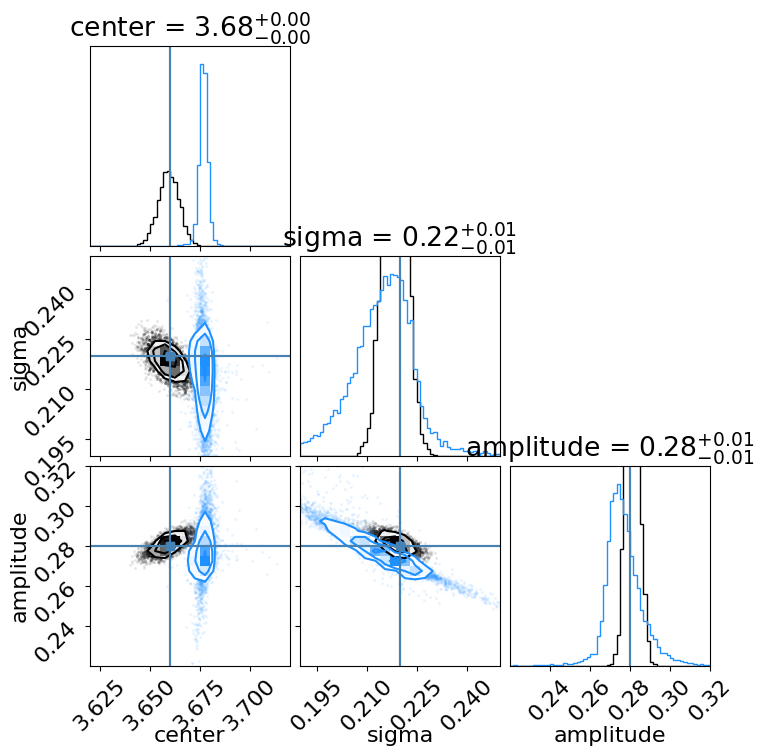

In [58]:
#plot nested sampling posterior
samples = sresults.samples_equal()
narrow=[(3.62,3.72),(0.19,0.25),(0.22,0.32)]
broad=[(3.2,4),(0.1,0.3),(0.2,0.5)]
CORNER_KWARGS=dict(
    plot_density=True,
    hist_bin_factor=3,
    plot_contours=True,
    show_titles=True,
    truths=[3.66, 0.22, 0.28],
    range=narrow,
    color='k'
)
ns = corner(sresults.samples_equal(), **CORNER_KWARGS)

# CORNER_KWARGS=dict(
#     plot_density=True,
#     hist_bin_factor=3,
#     plot_contours=True,
#     show_titles=True,
#     truths=[3.66, 0.22, 0.28],
#     range=broad,
#     fig=ns,
#     color='coral'
# )
# # fig=R_maf.plot_corner( n_samples=len(samples),**CORNER_KWARGS)
# fig=corner(maf, **CORNER_KWARGS)

# CORNER_KWARGS=dict(
#     plot_density=True,
#     hist_bin_factor=3,
#     plot_contours=True,
#     show_titles=True,
#     truths=[3.66, 0.22, 0.28],
#     range=broad,
#     fig=ns,
#     color='forestgreen'
# )
# # fig=R_made.plot_corner( n_samples=len(samples),**CORNER_KWARGS)
# figure = corner(made, **CORNER_KWARGS)
# # fig = corner(np.vstack(draws), **CORNER_KWARGS)

CORNER_KWARGS=dict(
    plot_density=True,
    hist_bin_factor=3,
    plot_contours=True,
    show_titles=True,
    truths=[3.66, 0.22, 0.28],
    range=narrow,
    fig=ns,
    color='dodgerblue'
)
fig=R.plot_corner(n_samples=len(samples),**CORNER_KWARGS)
# figure = corner(nsf, **CORNER_KWARGS)

### Posterior predictive check

100%|██████████| 100/100 [00:00<00:00, 3383.76it/s]


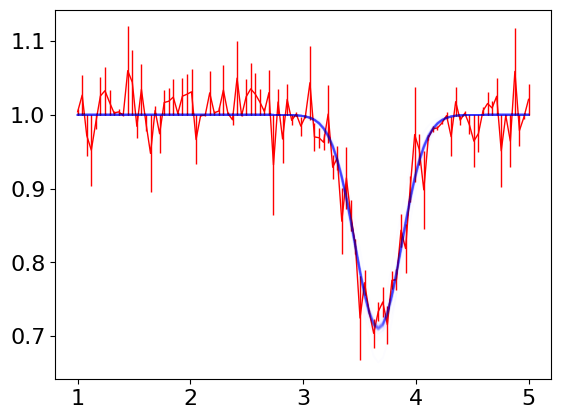

In [41]:
xs = R.post_x
# Xs=np.concatenate(list(xs.values()), axis=1)

# plt.figure(figsize=)
for key in R.obs.keys():
    plt.errorbar(x=R.obs[key][:,0], y=R.obs[key][:,1], yerr=abs(R.obs[key][:,2]), c='r', lw=1, zorder=0)
for i in trange(len(xs[0])):
    for key in R.obs.keys():
        plt.plot(R.obs[key][:,0], xs[key][i], c='b', alpha=0.01, zorder=1)
# plt.xlim(1.5,3.5)
# plt.ylim(0.5,1.05)

In [299]:
from floppity import plot_utils
plot_utils.plot_moment_evolution(R.proposals[:], 5, helpers.compute_moments, R=R, num_repeats=3, sample_size=1000)

TypeError: compute_moments() takes 1 positional argument but 3 were given

## Ensemble retrieval

In [51]:
R = {}
post_draws=[]

n_ens = 5

training_kwargs= dict(
    stop_after_epochs = 10,
    num_atoms = 10,
    learning_rate=5e-4
)

flow_kwargs=dict(
    flow='nsf',
    bins=3,
    transforms=5,
    blocks=2,
    hidden=32,
    dropout=0.8
)

In [52]:
for i in range(n_ens):
    R[i] = Retrieval(mock_simulator)

    ### Get observation
    R[i].get_obs(["../src/floppity/data/obs_3.66_0.22_0.28.txt"])

    ### Add parameters
    R[i].add_parameter('center', 1, 5)
    R[i].add_parameter('sigma', 0.1, 0.7)
    R[i].add_parameter('amplitude', 0, 1)

    R[i].run(
        flow_kwargs=flow_kwargs, 
        resume=False, 
        n_threads=1,
        n_aug=1, 
        training_kwargs=training_kwargs, 
        n_rounds=10, 
        n_samples=50
        )

    post_draws.append(helpers.convert_cube(R[i].proposals[-1].sample((1000,)), R[i].parameters))
post_equal_weights = np.vstack(post_draws)

Starting training...
Round 1
 Neural network successfully converged after 32 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 32
        Best validation performance: -0.5154
        -------------------------
        
Round 2


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 143 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 143
        Best validation performance: -4.1572
        -------------------------
        
Round 3


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -5.6058
        -------------------------
        
Round 4


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -5.3738
        -------------------------
        
Round 5


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 36
        Best validation performance: -5.8947
        -------------------------
        
Round 6


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 64
        Best validation performance: -6.8907
        -------------------------
        
Round 7


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.
        -------------------------
        ||||| ROUND 7 STATS |||||:
        -------------------------
        Epochs trained: 47
        Best validation performance: -7.9015
        -------------------------
        
Round 8


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.
        -------------------------
        ||||| ROUND 8 STATS |||||:
        -------------------------
        Epochs trained: 64
        Best validation performance: -7.5215
        -------------------------
        
Round 9


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.
        -------------------------
        ||||| ROUND 9 STATS |||||:
        -------------------------
        Epochs trained: 37
        Best validation performance: -8.2096
        -------------------------
        
Round 10


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.
        -------------------------
        ||||| ROUND 10 STATS |||||:
        -------------------------
        Epochs trained: 44
        Best validation performance: -8.7516
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Starting training...
Round 1
 Neural network successfully converged after 93 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 93
        Best validation performance: -1.1959
        -------------------------
        
Round 2


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -3.4998
        -------------------------
        
Round 3


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 13 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 13
        Best validation performance: -3.9641
        -------------------------
        
Round 4


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 145 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 145
        Best validation performance: -5.0725
        -------------------------
        
Round 5


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 49
        Best validation performance: -7.6523
        -------------------------
        
Round 6


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 57
        Best validation performance: -7.7863
        -------------------------
        
Round 7


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.
        -------------------------
        ||||| ROUND 7 STATS |||||:
        -------------------------
        Epochs trained: 51
        Best validation performance: -8.1426
        -------------------------
        
Round 8


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 8 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -7.3617
        -------------------------
        
Round 9


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.
        -------------------------
        ||||| ROUND 9 STATS |||||:
        -------------------------
        Epochs trained: 41
        Best validation performance: -9.1638
        -------------------------
        
Round 10


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.
        -------------------------
        ||||| ROUND 10 STATS |||||:
        -------------------------
        Epochs trained: 52
        Best validation performance: -9.1777
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Starting training...
Round 1
 Neural network successfully converged after 109 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 109
        Best validation performance: -2.3448
        -------------------------
        
Round 2


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 31
        Best validation performance: -3.8124
        -------------------------
        
Round 3


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 62 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 62
        Best validation performance: -4.2120
        -------------------------
        
Round 4


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -3.6564
        -------------------------
        
Round 5


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 30
        Best validation performance: -6.1461
        -------------------------
        
Round 6


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 65 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 65
        Best validation performance: -7.0187
        -------------------------
        
Round 7


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 7 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -7.6619
        -------------------------
        
Round 8


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 61 epochs.
        -------------------------
        ||||| ROUND 8 STATS |||||:
        -------------------------
        Epochs trained: 61
        Best validation performance: -8.3066
        -------------------------
        
Round 9


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 71 epochs.
        -------------------------
        ||||| ROUND 9 STATS |||||:
        -------------------------
        Epochs trained: 71
        Best validation performance: -8.9109
        -------------------------
        
Round 10


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.
        -------------------------
        ||||| ROUND 10 STATS |||||:
        -------------------------
        Epochs trained: 51
        Best validation performance: -9.9979
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Starting training...
Round 1
 Neural network successfully converged after 48 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 48
        Best validation performance: -0.8273
        -------------------------
        
Round 2


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 40
        Best validation performance: -2.3491
        -------------------------
        
Round 3


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 62 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 62
        Best validation performance: -3.3752
        -------------------------
        
Round 4


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 16 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 16
        Best validation performance: -3.6618
        -------------------------
        
Round 5


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -4.3766
        -------------------------
        
Round 6


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 57
        Best validation performance: -6.5829
        -------------------------
        
Round 7


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 77 epochs.
        -------------------------
        ||||| ROUND 7 STATS |||||:
        -------------------------
        Epochs trained: 77
        Best validation performance: -7.3293
        -------------------------
        
Round 8


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.
        -------------------------
        ||||| ROUND 8 STATS |||||:
        -------------------------
        Epochs trained: 31
        Best validation performance: -6.6945
        -------------------------
        
Round 9


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 66 epochs.
        -------------------------
        ||||| ROUND 9 STATS |||||:
        -------------------------
        Epochs trained: 66
        Best validation performance: -7.3553
        -------------------------
        
Round 10


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 10 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -7.2436
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Starting training...
Round 1
 Neural network successfully converged after 64 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 64
        Best validation performance: -1.3258
        -------------------------
        
Round 2


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -3.2748
        -------------------------
        
Round 3


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 26
        Best validation performance: -2.7490
        -------------------------
        
Round 4


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 11 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 11
        Best validation performance: -2.8041
        -------------------------
        
Round 5


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 99 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 99
        Best validation performance: -4.3655
        -------------------------
        
Round 6


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 16 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 16
        Best validation performance: -5.5936
        -------------------------
        
Round 7


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.
        -------------------------
        ||||| ROUND 7 STATS |||||:
        -------------------------
        Epochs trained: 53
        Best validation performance: -6.1725
        -------------------------
        
Round 8


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 74 epochs.
        -------------------------
        ||||| ROUND 8 STATS |||||:
        -------------------------
        Epochs trained: 74
        Best validation performance: -7.6298
        -------------------------
        
Round 9


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs.
        -------------------------
        ||||| ROUND 9 STATS |||||:
        -------------------------
        Epochs trained: 39
        Best validation performance: -8.3730
        -------------------------
        
Round 10


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.
        -------------------------
        ||||| ROUND 10 STATS |||||:
        -------------------------
        Epochs trained: 41
        Best validation performance: -7.9254
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

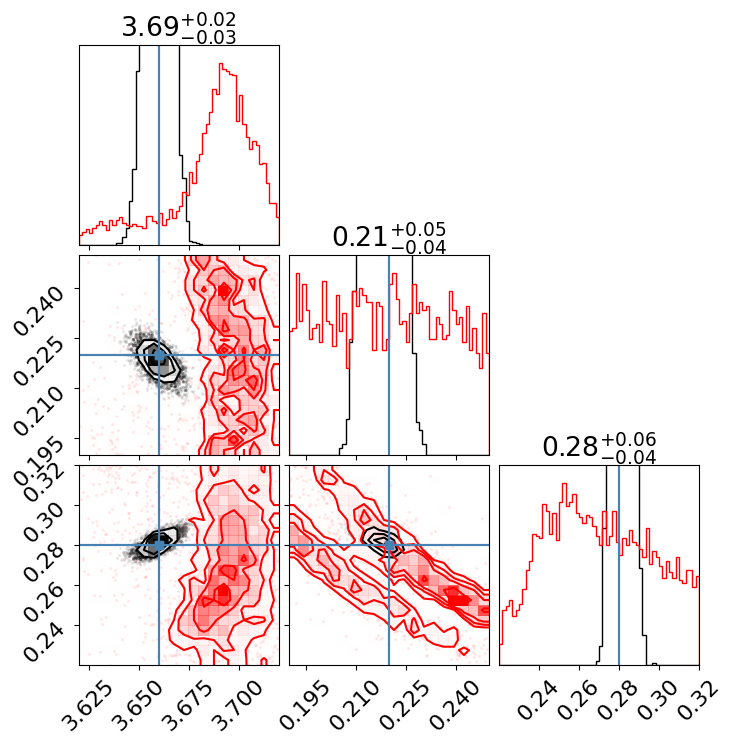

In [53]:
#plot nested sampling posterior
samples = sresults.samples_equal()
narrow=[(3.62,3.72),(0.19,0.25),(0.22,0.32)]
broad=[(1.,5),(0.1,0.7),(0.,1)]
CORNER_KWARGS=dict(
    plot_density=True,
    hist_bin_factor=3,
    plot_contours=True,
    show_titles=True,
    truths=[3.66, 0.22, 0.28],
    range=narrow,
    color='k'
)
ns = corner(sresults.samples_equal(), **CORNER_KWARGS)

CORNER_KWARGS=dict(
    plot_density=True,
    hist_bin_factor=3,
    plot_contours=True,
    show_titles=True,
    truths=[3.66, 0.22, 0.28],
    range=narrow,
    fig=ns,
    color='red'
)
# fig=R.plot_corner(-1,n_samples=len(samples),**CORNER_KWARGS)
# figure = corner(agg_samples, **CORNER_KWARGS)
fig = corner(post_equal_weights, **CORNER_KWARGS)